In [1]:
# Download cloning data, created with simulator
!git clone https://github.com/vsandul/Track

fatal: destination path 'Track' already exists and is not an empty directory.


In [2]:
!ls Track

IMG             driving_log.csv


In [3]:
!pip3 install imgaug

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dropout, Dense, Flatten
import cv2
import pandas as pd
import random
import os
import ntpath
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg

from imgaug import augmenters as iaa

In [5]:
datadir = 'Track'
columns = ['center','left','right','steering','throttle','reverse','speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', None)
data.head()

center   
0  /Users/vlad/Self Driving Cars Udemy/Data/IMG/center_2024_10_23_16_45_50_107.jpg  \
1  /Users/vlad/Self Driving Cars Udemy/Data/IMG/center_2024_10_23_16_45_50_208.jpg   
2  /Users/vlad/Self Driving Cars Udemy/Data/IMG/center_2024_10_23_16_45_50_312.jpg   
3  /Users/vlad/Self Driving Cars Udemy/Data/IMG/center_2024_10_23_16_45_50_419.jpg   
4  /Users/vlad/Self Driving Cars Udemy/Data/IMG/center_2024_10_23_16_45_50_519.jpg   

                                                                             left   
0   /Users/vlad/Self Driving Cars Udemy/Data/IMG/left_2024_10_23_16_45_50_107.jpg  \
1   /Users/vlad/Self Driving Cars Udemy/Data/IMG/left_2024_10_23_16_45_50_208.jpg   
2   /Users/vlad/Self Driving Cars Udemy/Data/IMG/left_2024_10_23_16_45_50_312.jpg   
3   /Users/vlad/Self Driving Cars Udemy/Data/IMG/left_2024_10_23_16_45_50_419.jpg   
4   /Users/vlad/Self Driving Cars Udemy/Data/IMG/left_2024_10_23_16_45_50_519.jpg   

                                                                             right   
0   /Users/vlad/Self Driving Cars Udemy/Data/IMG/right_2024_10_23_16_45_50_107.jpg  \
1   /Users/vlad/Self Driving Cars Udemy/Data/IMG/right_2024_10_23_16_45_50_208.jpg   
2   /Users/vlad/Self Driving Cars Udemy/Data/IMG/right_2024_10_23_16_45_50_312.jpg   
3   /Users/vlad/Self Driving Cars Udemy/Data/IMG/right_2024_10_23_16_45_50_419.jpg   
4   /Users/vlad/Self Driving Cars Udemy/Data/IMG/right_2024_10_23_16_45_50_519.jpg   

   steering  throttle  reverse     speed  
0       0.0       0.0      0.0  10.60721  
1       0.0       0.0      0.0  10.50075  
2       0.0       0.0      0.0  10.39535  
3       0.0       0.0      0.0  10.27027  
4       0.0       0.0      0.0  10.16710

In [7]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

center                              left   
0  center_2024_10_23_16_45_50_107.jpg  left_2024_10_23_16_45_50_107.jpg  \
1  center_2024_10_23_16_45_50_208.jpg  left_2024_10_23_16_45_50_208.jpg   
2  center_2024_10_23_16_45_50_312.jpg  left_2024_10_23_16_45_50_312.jpg   
3  center_2024_10_23_16_45_50_419.jpg  left_2024_10_23_16_45_50_419.jpg   
4  center_2024_10_23_16_45_50_519.jpg  left_2024_10_23_16_45_50_519.jpg   

                               right  steering  throttle  reverse     speed  
0  right_2024_10_23_16_45_50_107.jpg       0.0       0.0      0.0  10.60721  
1  right_2024_10_23_16_45_50_208.jpg       0.0       0.0      0.0  10.50075  
2  right_2024_10_23_16_45_50_312.jpg       0.0       0.0      0.0  10.39535  
3  right_2024_10_23_16_45_50_419.jpg       0.0       0.0      0.0  10.27027  
4  right_2024_10_23_16_45_50_519.jpg       0.0       0.0      0.0  10.16710

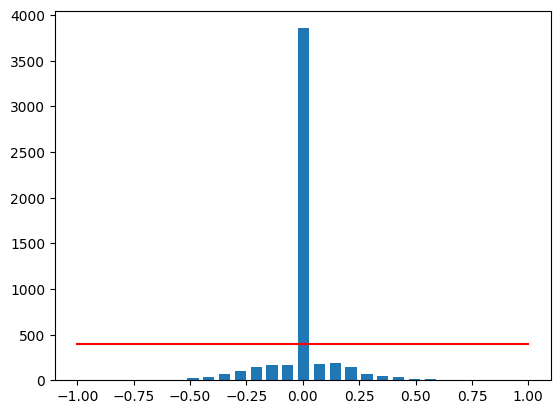

In [8]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:]) * 0.5

plt.bar(center,hist,width=0.05)
plt.plot((-1,1),(samples_per_bin,samples_per_bin),color='r')
plt.show()

total data 5289
Removed: 3456
Remaining: 1833


<BarContainer object of 25 artists>

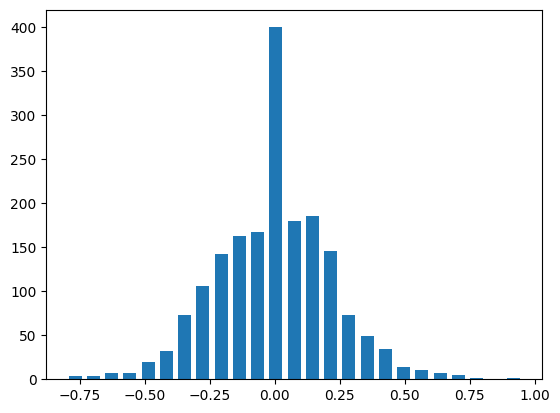

In [9]:
# reduce bias of driving forward
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('total data', len(data))
print('Removed:', len(remove_list))

data.drop(data.index[remove_list], inplace=True)
print('Remaining:', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)

In [10]:
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=1)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 1466
Valid Samples: 367


Text(0.5, 1.0, 'Validation set')

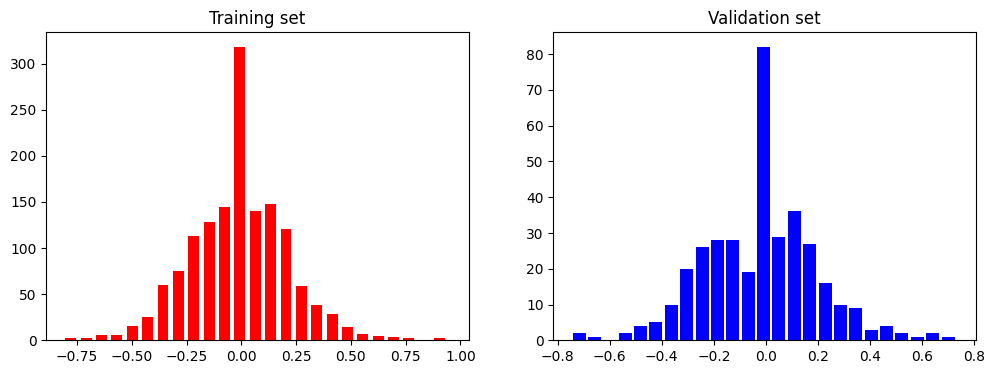

In [12]:
fig, axs = plt.subplots(1,2, figsize=(12,4))
axs[0].hist(y_train, bins=num_bins, width=0.05, color='red')
axs[0].set_title('Training set')
axs[1].hist(y_valid, bins=num_bins, width=0.05, color='blue')
axs[1].set_title('Validation set')

## data augmentation - image transformations

In [13]:
def zoom(image):
  zoom = iaa.Affine(scale=(1,1.3))
  image = zoom.augment_image(image)
  return image

Text(0.5, 1.0, 'Zoomed Image')

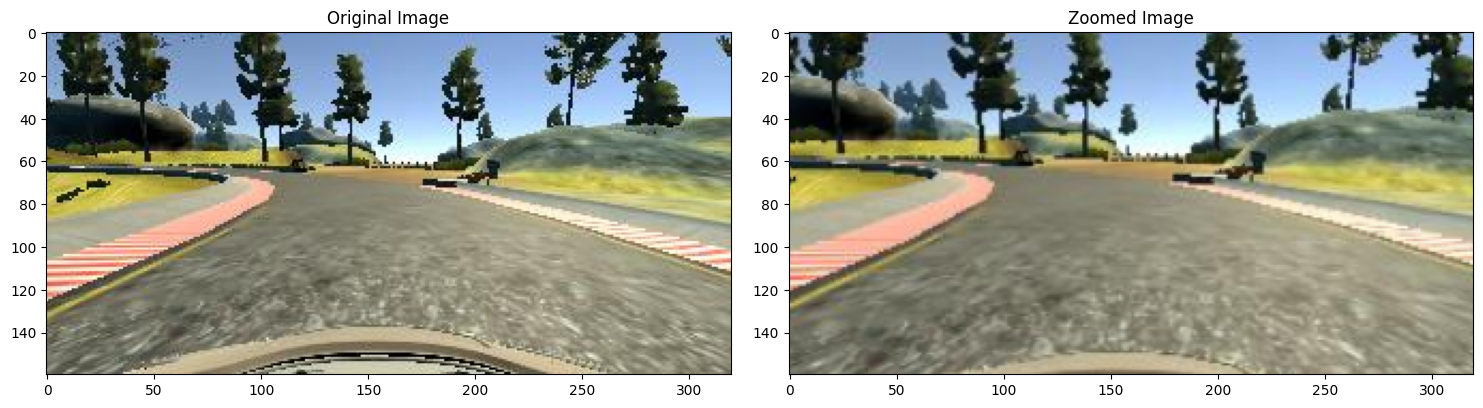

In [14]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axs = plt.subplots(1,2, figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

In [15]:
# pan shift
def pan(image):
  pan = iaa.Affine(translate_percent={'x':(-0.1,0.1), 'y':(-0.1,0.1)})
  image = pan.augment_image(image)
  return image

Text(0.5, 1.0, 'Panned Image')

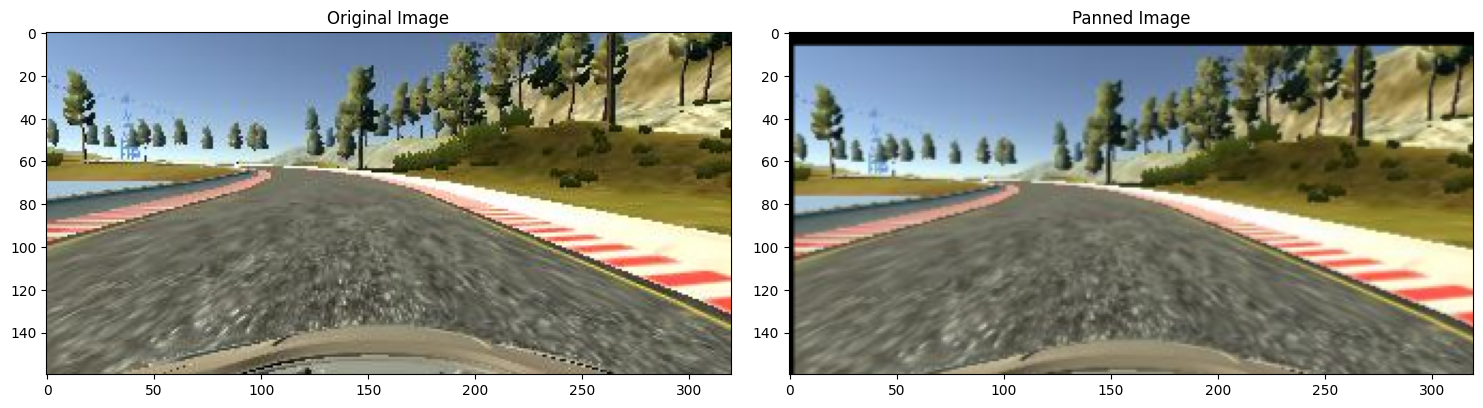

In [16]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig, axs = plt.subplots(1,2, figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

In [17]:
def image_random_brightness(image):
  brightness = iaa.Multiply((0.2,1.2))
  image = brightness.augment_image(image)
  return image

Text(0.5, 1.0, 'Brightness altered Image')

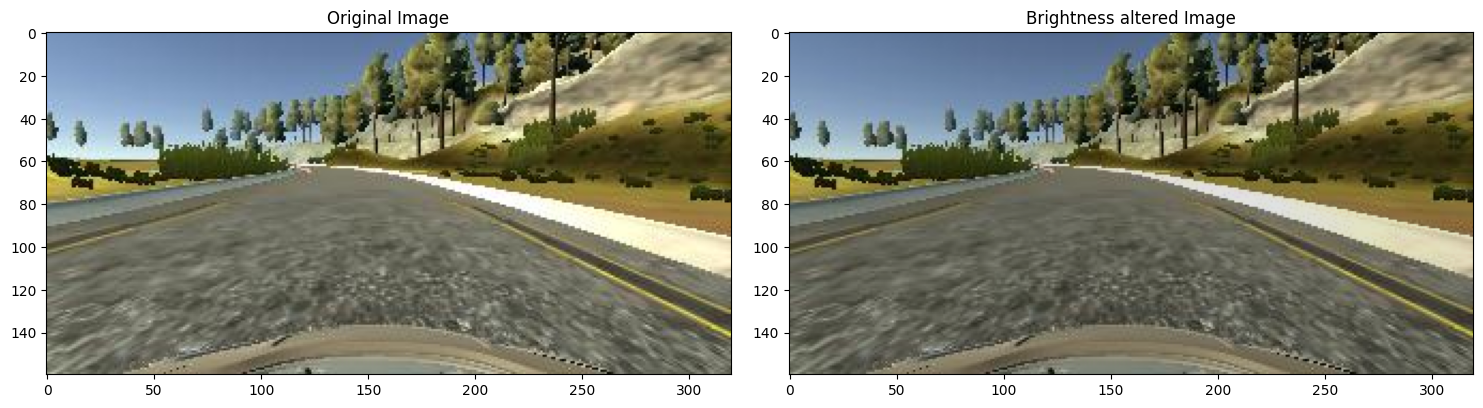

In [18]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
brightness_altered_image = image_random_brightness(original_image)

fig, axs = plt.subplots(1,2, figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered Image')

In [19]:
def img_random_flip(image, steering_angle):
  image = cv2.flip(image,1)
  steering_angle = -steering_angle
  return image, steering_angle

Text(0.5, 1.0, 'Flipped Image - Steering Angle:0.2047563')

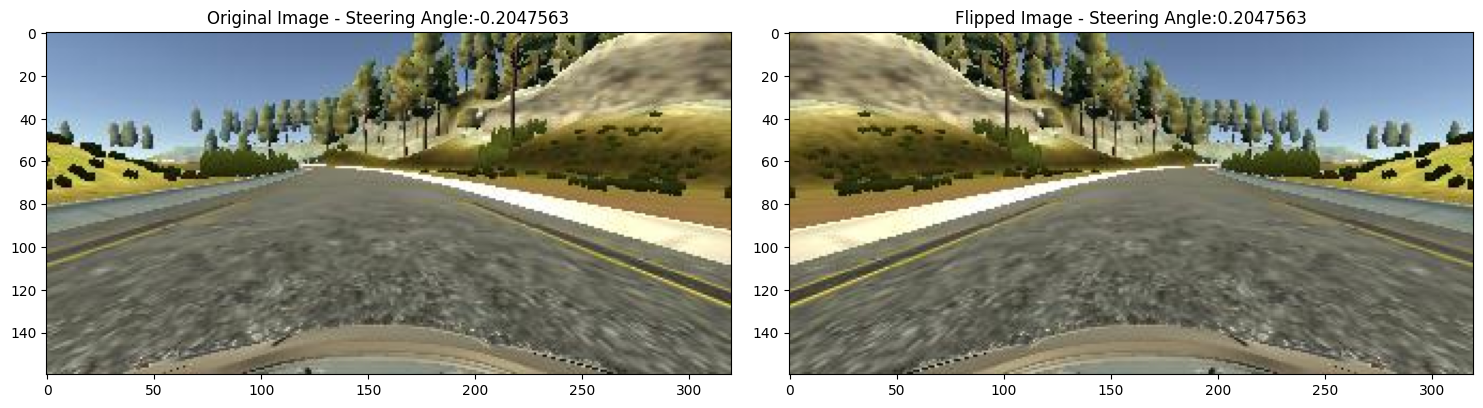

In [20]:
image = image_paths[random.randint(0,1000)]
steering_angle = steerings[random.randint(0,1000)]
original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

fig, axs = plt.subplots(1,2, figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))
axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))

In [21]:
def random_augment(image, steering_angle):
  image = mpimg.imread(image)
  if np.random.rand() < 0.5:
    image = pan(image)
  if np.random.rand() < 0.5:
    image = zoom(image)
  if np.random.rand() < 0.5:
    image = image_random_brightness(image)
  if np.random.rand() < 0.5:
    image, steering_angle = img_random_flip(image, steering_angle)

  return image, steering_angle

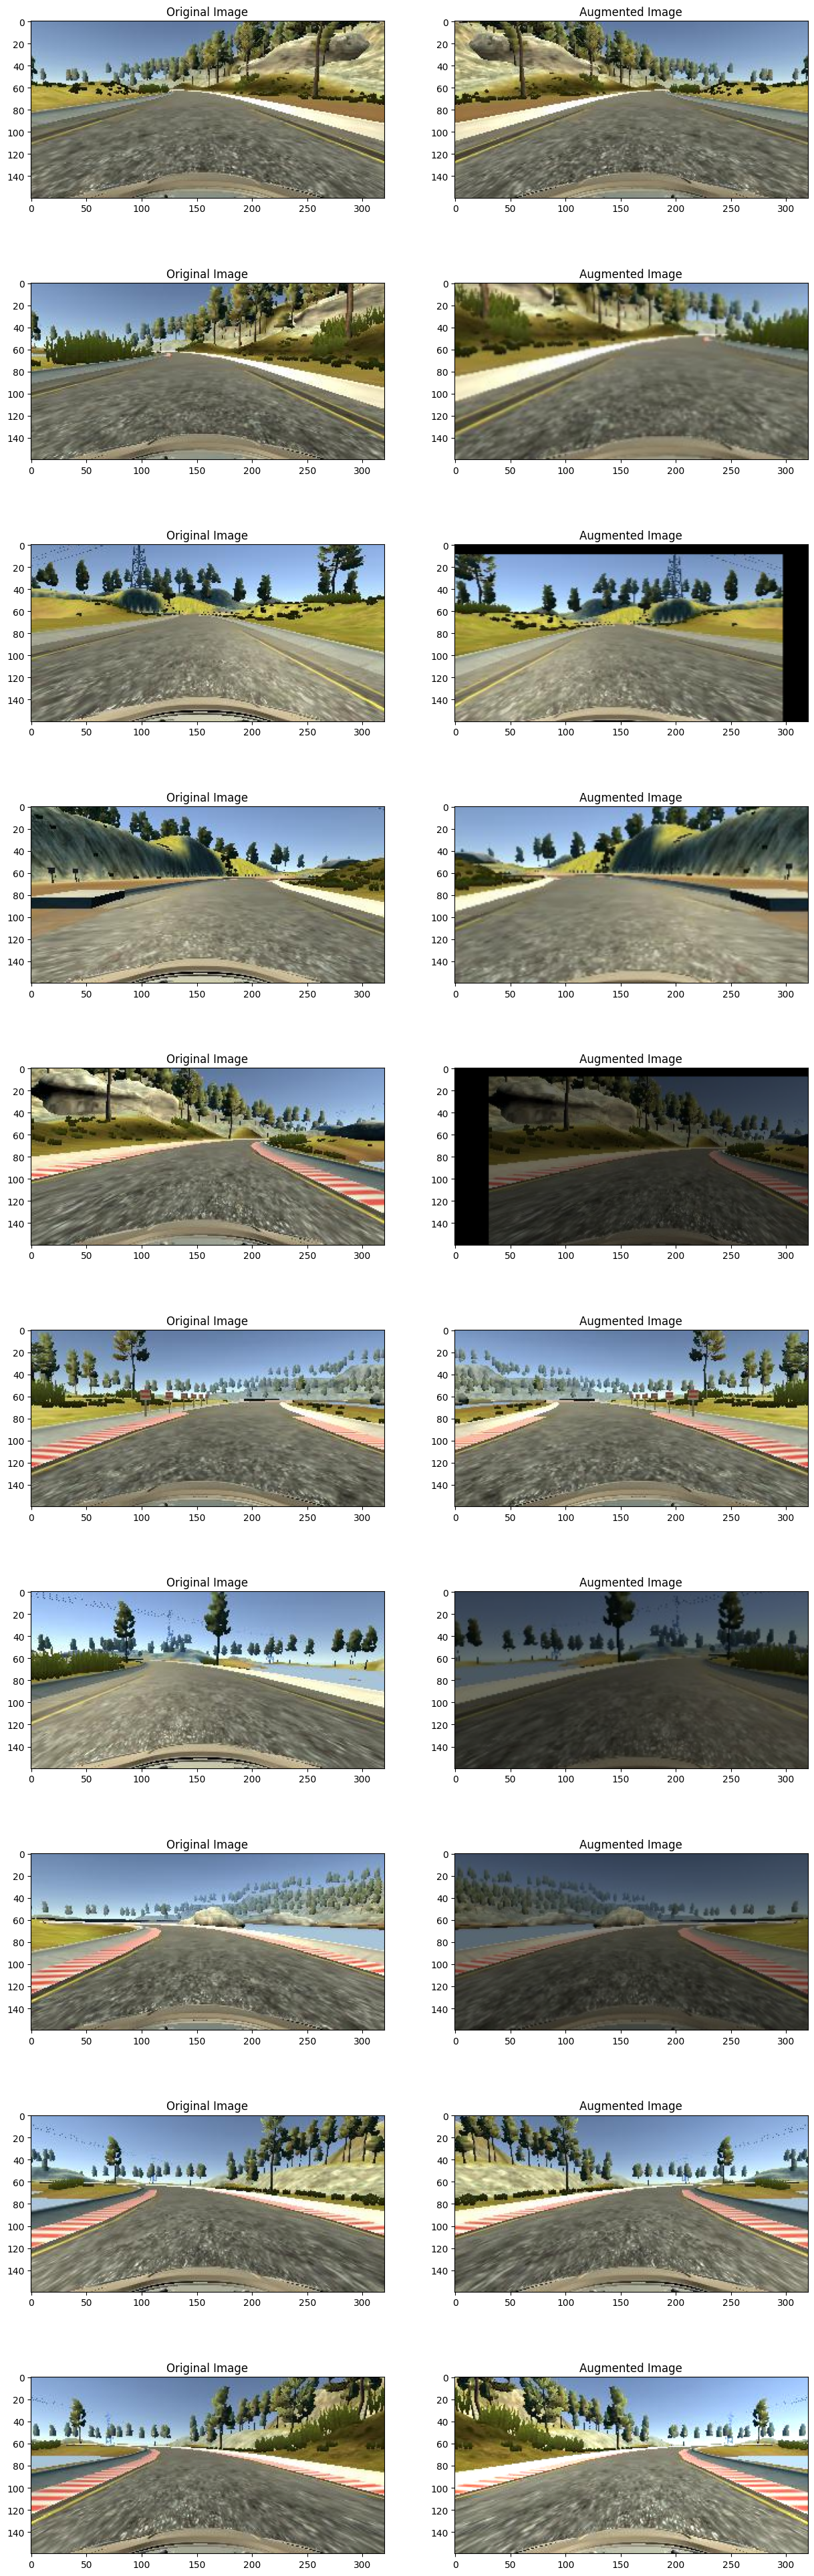

In [22]:
ncol, nrow = 2, 10
fig, axs = plt.subplots(nrow, ncol, figsize=(15,50))
fig.tight_layout
for i in range(10):
  rand_num = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[rand_num]
  random_steering = steerings[rand_num]
  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)
  axs[i][0].imshow(original_image)
  axs[i][0].set_title('Original Image')
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title('Augmented Image')

In [30]:
# convert image into data format; yuv is better for NVidia model
def image_preprocess(img):
  #img = mpimg.imread(img)
  img = img[60:135,:,:]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3,3), 0)
  img = cv2.resize(img, (200,66))
  img = img/255
  return img

Text(0.5, 1.0, 'Preprocessed Image')

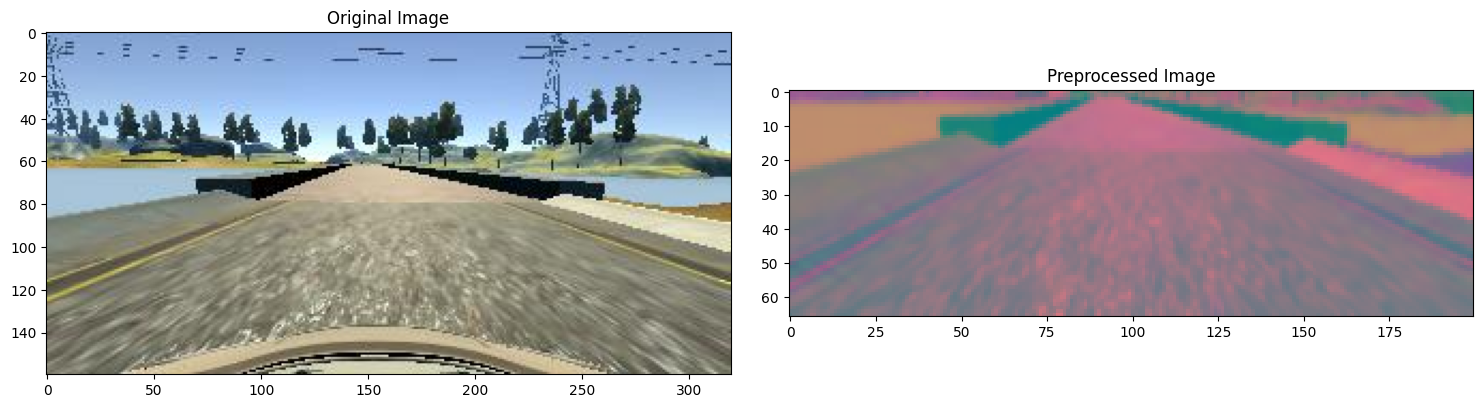

In [24]:
image = image_paths[123]
original_image = mpimg.imread(image)
preprocessed_image = image_preprocess(original_image)

fig, axs = plt.subplots(1,2, figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [25]:
def batch_generator(image_paths, steering_ang, batch_size, is_training):
  while True:
    batch_img = []
    batch_steering = []

    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)

      if is_training:
        img, steering = random_augment(image_paths[random_index], steering_ang[random_index])
      else:
        img = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]

      img = image_preprocess(img)
      batch_img.append(img)
      batch_steering.append(steering)

    yield (np.asarray(batch_img), np.asarray(batch_steering))

Text(0.5, 1.0, 'Validation Image')

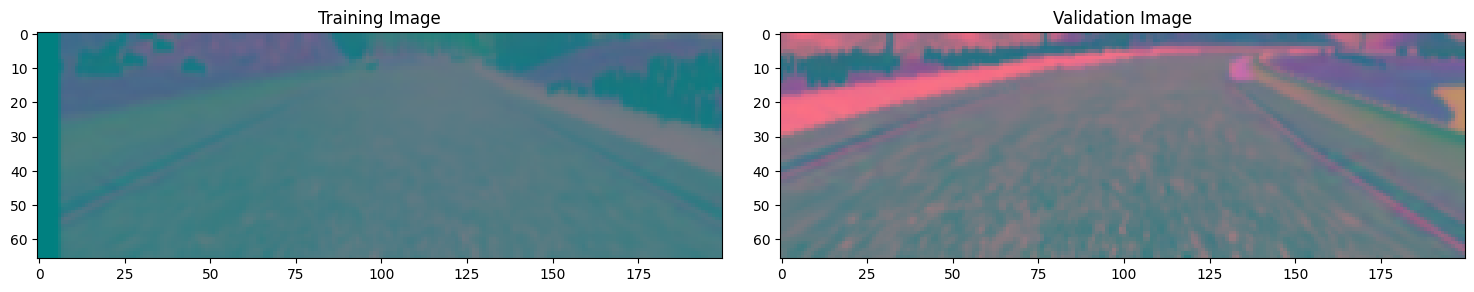

In [26]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

fig, axs = plt.subplots(1,2, figsize=(15,10))
fig.tight_layout()
axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')
axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

# NVIDIA model

In [27]:
def nvidia_model():
  model = Sequential()
  act_func = 'elu'
  model.add(Conv2D(24, kernel_size=(5,5), strides=(2,2), input_shape=(66,200,3),activation=act_func))
  model.add(Conv2D(36, kernel_size=(5,5), strides=(2,2), activation=act_func))
  model.add(Conv2D(48, kernel_size=(5,5), strides=(2,2), activation=act_func))
  model.add(Conv2D(64, kernel_size=(3,3), activation=act_func))
  model.add(Conv2D(64, kernel_size=(3,3), activation=act_func))
  #model.add(Dropout(0.5))

  model.add(Flatten())
  model.add(Dense(100, activation=act_func))
  #model.add(Dropout(0.5))
  model.add(Dense(50, activation=act_func))
  #model.add(Dropout(0.5))
  model.add(Dense(10, activation =act_func))
  #model.add(Dropout(0.5))
  model.add(Dense(1))
  # remove dropout layers
  # increase learning rate in adam

  optimizer= Adam(learning_rate=1e-4)
  model.compile(loss='mse', optimizer=optimizer)

  return model

In [28]:
model = nvidia_model()
print(model.summary())

Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 flatten (Flatten)           (None, 1152)              0         


2024-11-08 15:35:27.200480: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-08 15:35:27.200910: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


                                                                 
 dense (Dense)               (None, 100)               115300    
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 10)                510       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 252,219
Trainable params: 252,219
Non-trainable params: 0
_________________________________________________________________
None


In [29]:
history = model.fit(batch_generator(X_train, y_train, 100, 1), steps_per_epoch=300, epochs=10, validation_data=batch_generator(X_valid, y_valid, 100, 0), validation_steps=200, verbose=1, shuffle=1)

Epoch 1/10


2024-11-08 15:35:30.851739: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-11-08 15:35:31.180249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


300/300 [==============================] - ETA: 0s - loss: 0.0398

2024-11-08 15:36:16.331604: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


300/300 [==============================] - 59s 196ms/step - loss: 0.0398 - val_loss: 0.0269
Epoch 2/10
300/300 [==============================] - 57s 190ms/step - loss: 0.0330 - val_loss: 0.0251
Epoch 3/10
300/300 [==============================] - 57s 189ms/step - loss: 0.0302 - val_loss: 0.0247
Epoch 4/10
300/300 [==============================] - 57s 190ms/step - loss: 0.0281 - val_loss: 0.0231
Epoch 5/10
300/300 [==============================] - 63s 210ms/step - loss: 0.0262 - val_loss: 0.0215
Epoch 6/10
300/300 [==============================] - 67s 224ms/step - loss: 0.0247 - val_loss: 0.0235
Epoch 7/10
300/300 [==============================] - 58s 195ms/step - loss: 0.0246 - val_loss: 0.0219
Epoch 8/10
300/300 [==============================] - 60s 200ms/step - loss: 0.0238 - val_loss: 0.0216
Epoch 9/10
300/300 [==============================] - 58s 194ms/step - loss: 0.0229 - val_loss: 0.0202
Epoch 10/10
300/300 [==============================] - 58s 193ms/step - loss: 0.0227

Text(0.5, 0, 'Epoch')

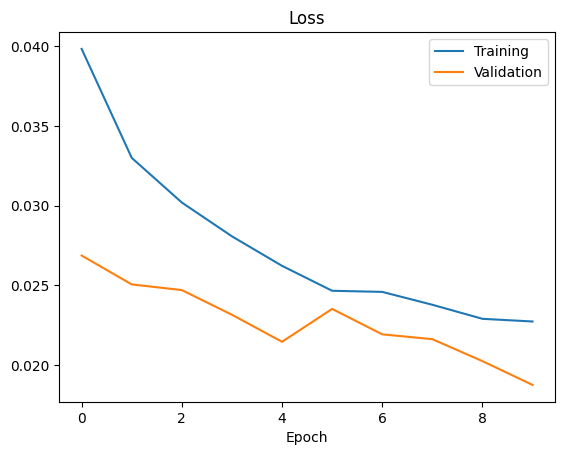

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [36]:
model.save('model.h5')

In [ ]:
# Download model from Google Colab
#from google.colab import files
#files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>